In [22]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False); 

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
from IPython.display import Image
from skimage import io
tf.__version__

'2.16.1'

## Object detection

- Ver los papers originales [Yolov3](https://pjreddie.com/media/files/papers/YOLOv3.pdf),  [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf)



### Enfoques:

- **Clásico**: ventana corredera, costosa
- **Detectores de dos etapas**: Primero obtenga las regiones propuestas, luego clasifique.
- **Detectores de una etapa**: use regiones anteriores en una cuadrícula de imágenes fija

### **Introducción**

Es posible construir una potente red neuronal profunda aumentando el número de capas en una red. Dos problemas con el enfoque anterior son que aumentar el número de capas de una red neuronal puede provocar un sobreajuste, especialmente si tiene datos de entrenamiento etiquetados limitados y hay una aumento en el requerimiento computacional.

Las redes de inicio se crearon con la idea de aumentar la capacidad de una red neuronal profunda y al mismo tiempo utilizar de manera eficiente los recursos computacionales.

Cito el artículo (Profundizando con las convoluciones) a continuación:

Proponemos una arquitectura de red neuronal convolucional profunda con nombre en código "Inception", que fue responsable de establecer el nuevo estado del arte para la clasificación y detección en el ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC 2014). La principal característica de esta arquitectura es la utilización mejorada de los recursos informáticos dentro de la red. Esto se logró mediante un diseño cuidadosamente elaborado que permite aumentar la profundidad y el ancho de la red manteniendo constante el costo computacional.

Las redes Inception se lanzan en versiones, cada versión tiene alguna mejora con respecto a las anteriores. Comencemos nuestra discusión con Inception Versión 1, también conocida como Inception V1.

### **La arquitectura de Inception V1**

Considere las siguientes imágenes de pavos reales. El área de la imagen ocupada por el pavo real varía en ambas imágenes, por lo que seleccionar el tamaño de núcleo correcto se convierte en una elección difícil. Se utiliza un tamaño de kernel grande para capturar una distribución global de la imagen, mientras que se usa un tamaño de kernel pequeño para capturar más información local.

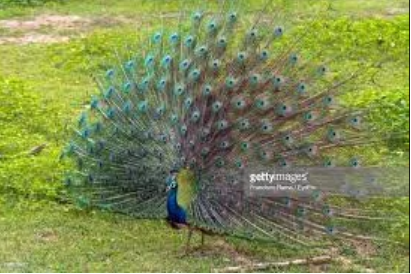

In [24]:
Image(filename='local/imgs/pavo_1.png', width=400)

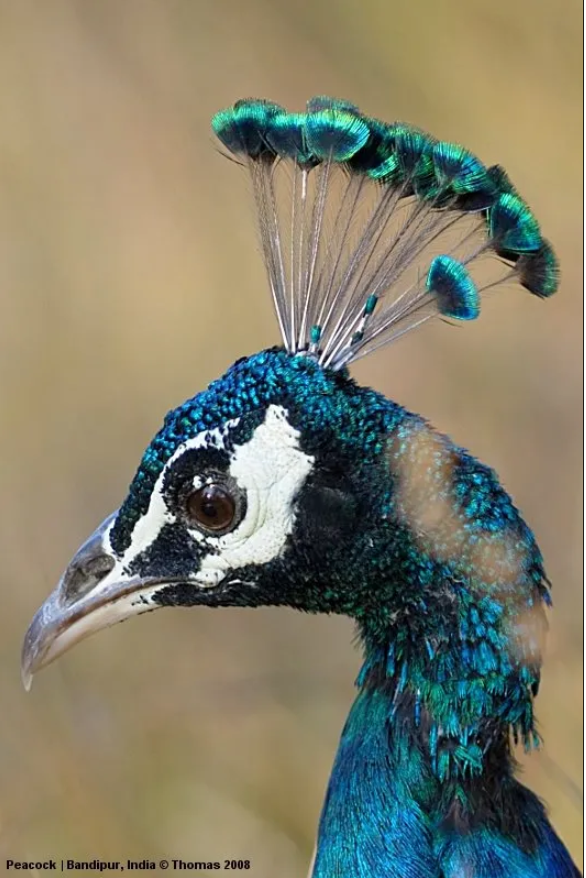

In [25]:
Image(filename='local/imgs/pavo_2.png', width=400)

La arquitectura de red inicial permite utilizar filtros de múltiples tamaños sin aumentar la profundidad de la red. Los diferentes filtros se añaden en paralelo en lugar de estar completamente conectados uno tras otro.

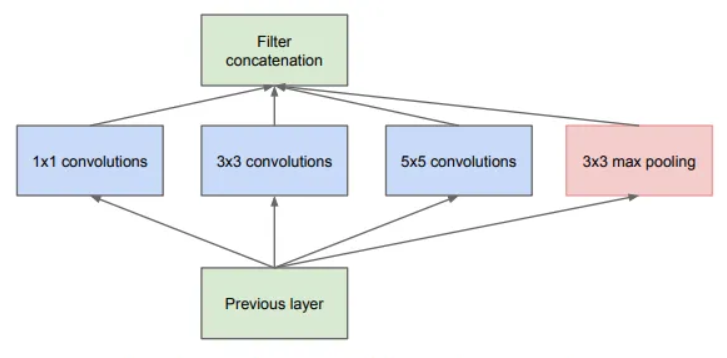

In [26]:
Image(filename='local/imgs/inception_1.png', width=600)

Esto se conoce como la versión ingenua del modelo inicial. El problema de este modelo era la gran cantidad de parámetros. Para mitigar lo mismo, se les ocurrió la siguiente arquitectura.

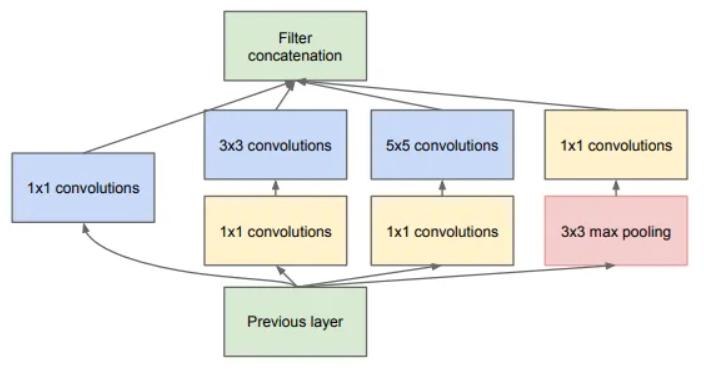

In [27]:
Image(filename='local/imgs/inception_2.png', width=600)

## **¿Cómo reduce esta arquitectura la dimensionalidad?**

Agregar una convolución 1X1 antes de una convolución 5X5 reduciría la cantidad de canales de la imagen cuando se proporciona como entrada a la convolución 5X5, lo que a su vez reduciría la cantidad de parámetros y los requisitos computacionales.

Dejame explicarte con un ejemplo.

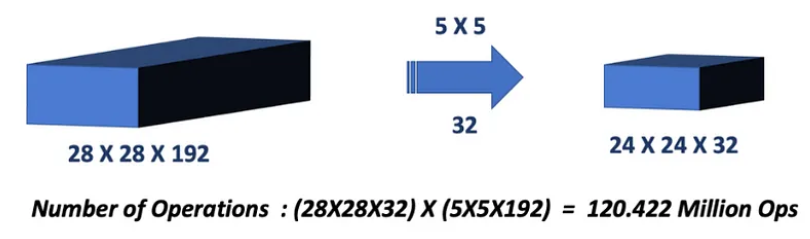

In [28]:
Image(filename='local/imgs/inception_3.png', width=600)

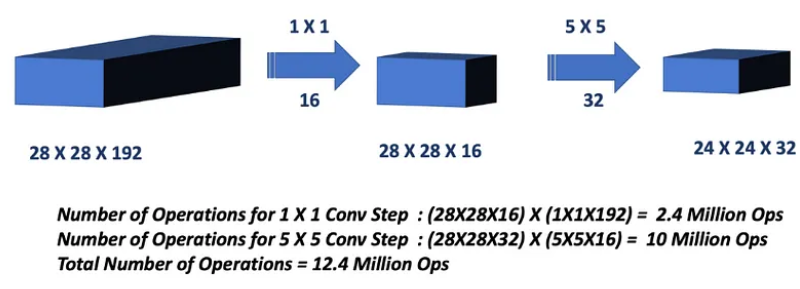

In [29]:
Image(filename='local/imgs/inception_4.png', width=600)

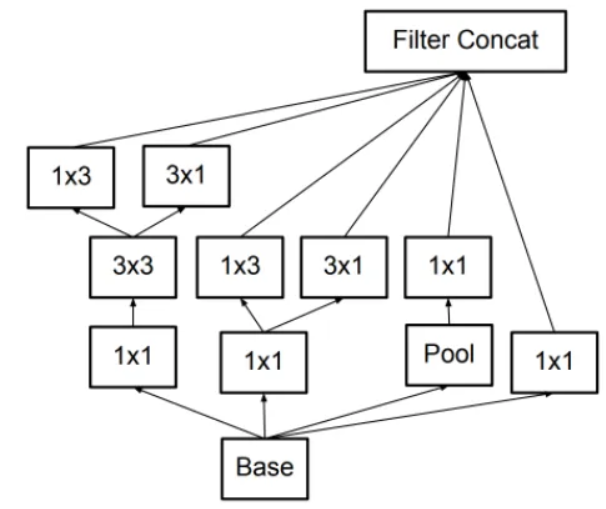

In [30]:
Image(filename='local/imgs/inception_5.png', width=600)

### **Uso del aprendizaje por transferencia (red inicial previamente entrenada) en un problema de clasificación de imágenes.**


### **¿En qué se diferencia la red Inception V3 de la red Inception V1?**

Inception V3 es una extensión del módulo V1, utiliza técnicas como factorizar convoluciones más grandes en convoluciones más pequeñas (por ejemplo, una convolución de 5X5 se factoriza en dos convoluciones de 3X3) y factorizaciones asimétricas (ejemplo: factorizar un filtro de 3X3 en un filtro de 1X3 y 3X1).

Estas factorizaciones se realizan con el objetivo de reducir la cantidad de parámetros que se utilizan en cada módulo inicial. A continuación se muestra una imagen del módulo inicial V3.

## Observe cómo se anota una imagen para su detección.

Este es un ejemplo del [Conjunto de datos Open Images V6](https://storage.googleapis.com/openimages/web/index.html), un conjunto de datos creado y seleccionado en Google. Explore e inspeccione imágenes y anotaciones para comprender el conjunto de datos.

Particularmente:

- obtenga una vista de la volumetría y las descripciones de clases en [https://storage.googleapis.com/openimages/web/factsfigures.html](https://storage.googleapis.com/openimages/web/factsfigures.html)
- comprender los formatos de anotación de imágenes en [https://storage.googleapis.com/openimages/web/download.html](https://storage.googleapis.com/openimages/web/download.html)

**Descargamos las descripciones de las clases**

In [31]:
!wget -nc https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
c = pd.read_csv("class-descriptions-boxable.csv", names=["code", "description"], index_col="code")
c.head()

El fichero ‘class-descriptions-boxable.csv’ ya está ahí, no se recupera.



description
code                   
/m/011k07      Tortoise
/m/011q46kg   Container
/m/012074        Magpie
/m/0120dh    Sea turtle
/m/01226z      Football

**UN ejemplo de imágen**

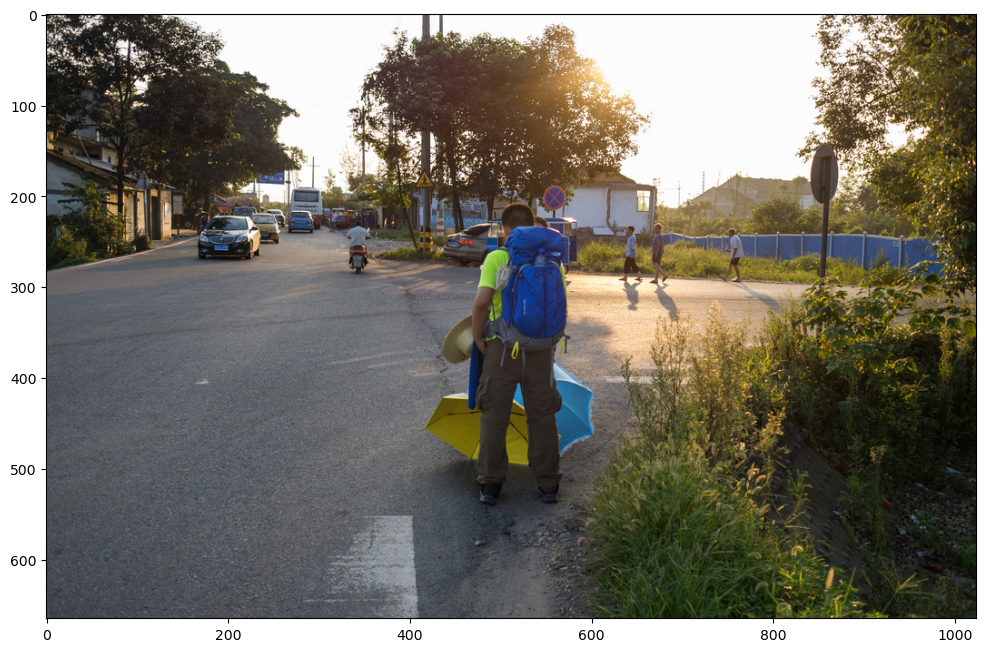

In [32]:
img = io.imread("local/data/0003bb040a62c86f.jpg")
plt.figure(figsize=(12,10))
plt.imshow(img)

**con sus anotaciones**

In [33]:
boxes = pd.read_csv("local/data/openimages_boxes_0003bb040a62c86f.csv")
boxes

ImageID     Source  LabelName  Confidence      XMin      XMax  \
0   0003bb040a62c86f  activemil   /m/07j7r           1  0.280625  0.658125   
1   0003bb040a62c86f     xclick  /m/01g317           1  0.326250  0.349375   
2   0003bb040a62c86f     xclick  /m/01g317           1  0.461875  0.553750   
3   0003bb040a62c86f     xclick  /m/01g317           1  0.620000  0.641875   
4   0003bb040a62c86f     xclick  /m/01g317           1  0.650625  0.671250   
5   0003bb040a62c86f     xclick  /m/01g317           1  0.726250  0.754375   
6   0003bb040a62c86f     xclick  /m/01mqdt           1  0.397500  0.416875   
7   0003bb040a62c86f     xclick  /m/01mqdt           1  0.533125  0.560000   
8   0003bb040a62c86f     xclick  /m/01prls           1  0.163750  0.233125   
9   0003bb040a62c86f     xclick  /m/01prls           1  0.201875  0.227500   
10  0003bb040a62c86f     xclick  /m/01prls           1  0.219375  0.255625   
11  0003bb040a62c86f     xclick  /m/01prls           1  0.235000  0.259375   
12  0003bb040a62c86f     xclick  /m/01prls           1  0.258125  0.289375   
13  0003bb040a62c86f     xclick  /m/01prls           1  0.260625  0.298750   
14  0003bb040a62c86f     xclick  /m/01prls           1  0.264375  0.297500   
15  0003bb040a62c86f     xclick  /m/01prls           1  0.311875  0.336250   
16  0003bb040a62c86f     xclick  /m/01prls           1  0.326250  0.353125   
17  0003bb040a62c86f     xclick  /m/01prls           1  0.424375  0.490000   
18  0003bb040a62c86f     xclick   /m/07j7r           1  0.000000  0.181875   
19  0003bb040a62c86f     xclick   /m/07j7r           1  0.113750  0.273750   
20  0003bb040a62c86f     xclick   /m/07j7r           1  0.761875  0.830000   
21  0003bb040a62c86f     xclick   /m/07j7r           1  0.799375  0.999375   
22  0003bb040a62c86f     xclick   /m/0hnnb           1  0.401250  0.555000   
23  0003bb040a62c86f     xclick   /m/0hnnb           1  0.501250  0.588125   

        YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0   0.021174  0.347449           1            1  ...            0         0   
1   0.346487  0.397498           0            0  ...            0         0   
2   0.312801  0.811357           1            0  ...            0         0   
3   0.350337  0.448508           0            0  ...            0         0   
4   0.344562  0.446583           0            0  ...            0         0   
5   0.354187  0.448508           0            0  ...            0         0   
6   0.256978  0.286814           0            0  ...            0         0   
7   0.281039  0.328200           0            0  ...            0         0   
8   0.325313  0.409047           0            0  ...            0         0   
9   0.316651  0.342637           1            0  ...            0         0   
10  0.323388  0.380173           1            0  ...            0         0   
11  0.316651  0.354187           1            0  ...            0         0   
12  0.323388  0.368624           1            0  ...            0         0   
13  0.282964  0.358037           1            0  ...            0         0   
14  0.292589  0.333975           1            0  ...            0         0   
15  0.330125  0.354187           1            0  ...            0         0   
16  0.351299  0.430221           1            0  ...            0         0   
17  0.342637  0.415784           1            0  ...            0         0   
18  0.000000  0.366699           1            1  ...            0         0   
19  0.080847  0.360924           0            0  ...            0         0   
20  0.302214  0.362849           0            0  ...            0         0   
21  0.000000  0.471607           0            1  ...            0         0   
22  0.628489  0.748797           1            0  ...            0         0   
23  0.570741  0.734360           1            0  ...            0         0   

    XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  -1.0000

**la anotacion de estas imágenes**


In [34]:
pd.Series([c.loc[i].description for i in boxes.LabelName]).value_counts()


Land vehicle    10
Tree             5
Person           5
Traffic sign     2
Umbrella         2
Name: count, dtype: int64

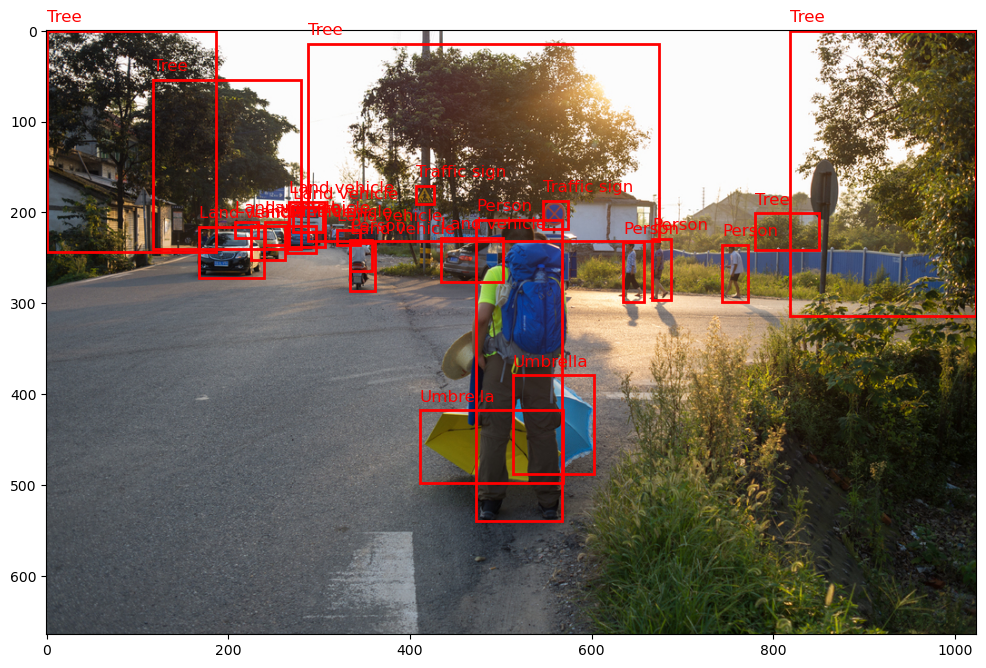

In [35]:
from matplotlib.patches import Rectangle
i = np.random.randint(len(boxes))
plt.figure(figsize=(12,10)); 
ax = plt.subplot(111)
plt.imshow(img)
h,w = img.shape[:2]
for i in range(len(boxes)):
    k = boxes.iloc[i]
    label = c.loc[k.LabelName].values[0]
    ax.add_patch(Rectangle((k.XMin*w,k.YMin*h),(k.XMax-k.XMin)*w,(k.YMax-k.YMin)*h, linewidth=2,edgecolor='r',facecolor='none'))
    plt.text(k.XMin*w, k.YMin*h-10, label, fontsize=12, color="red")

## **Clasificación de parches, con InceptionV3 de Keras**

algunos parches de muestra

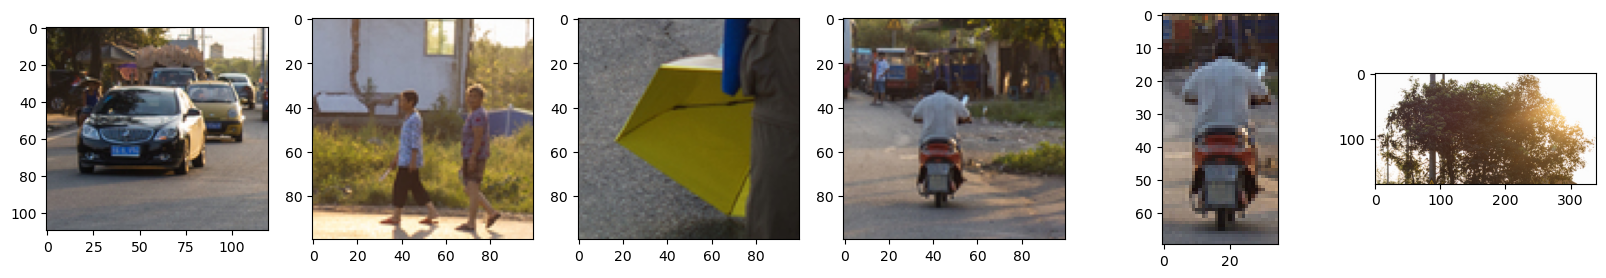

In [36]:
patches = [img[190:300, 150:270], 
           img[200:300, 600:700], 
           img[400:500, 400:500],
           img[200:300, 300:400],
           img[220:290, 325:360],
           img[10:180, 330:670]]

plt.figure(figsize=(20,3))
for i,pimg in enumerate(patches):
    plt.subplot(1,len(patches),i+1); plt.imshow(pimg)

In [37]:
from tensorflow.keras.applications import inception_v3
if not "model" in locals():
    model = inception_v3.InceptionV3(weights='imagenet', include_top=True)


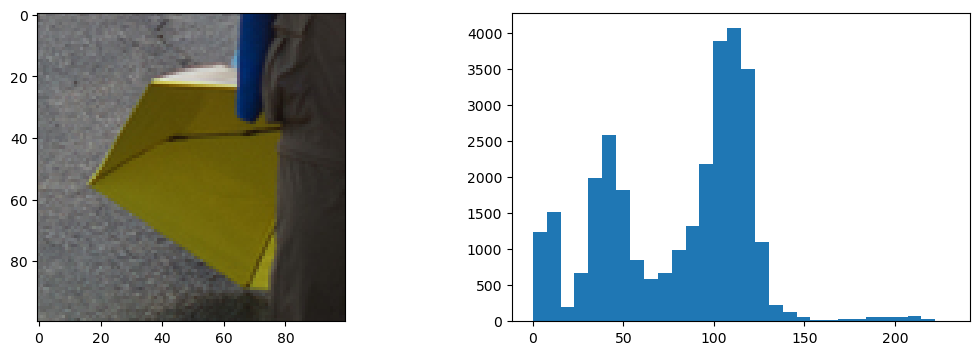

In [38]:
def plot_img_with_histogram(img):
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
    plt.subplot(122)
    plt.hist(img.flatten(), bins=30);

pimg = patches[2]

plot_img_with_histogram(pimg)

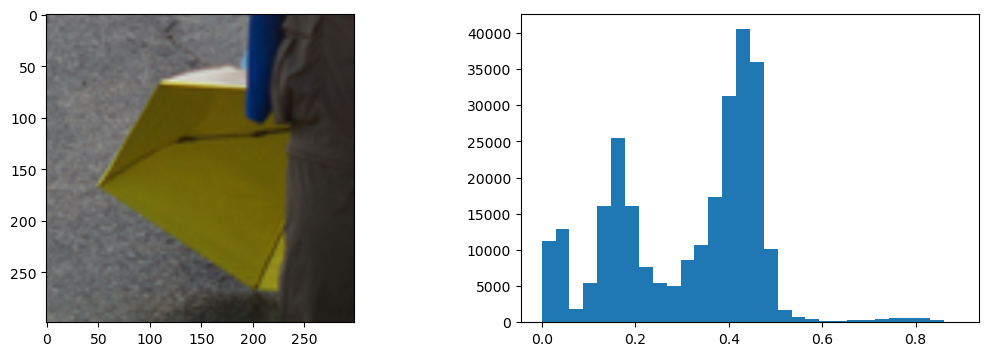

In [39]:
from skimage.transform import resize
rimg = resize(pimg, output_shape=(299,299,3))
plot_img_with_histogram(rimg)

In [40]:
pred = model.predict(rimg.reshape(-1,*rimg.shape))
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


(1, 1000)

In [41]:
k = pd.DataFrame(inception_v3.decode_predictions(pred, top=100)[0], columns=["code", "label", "preds"])
k = k.sort_values(by="preds", ascending=False)


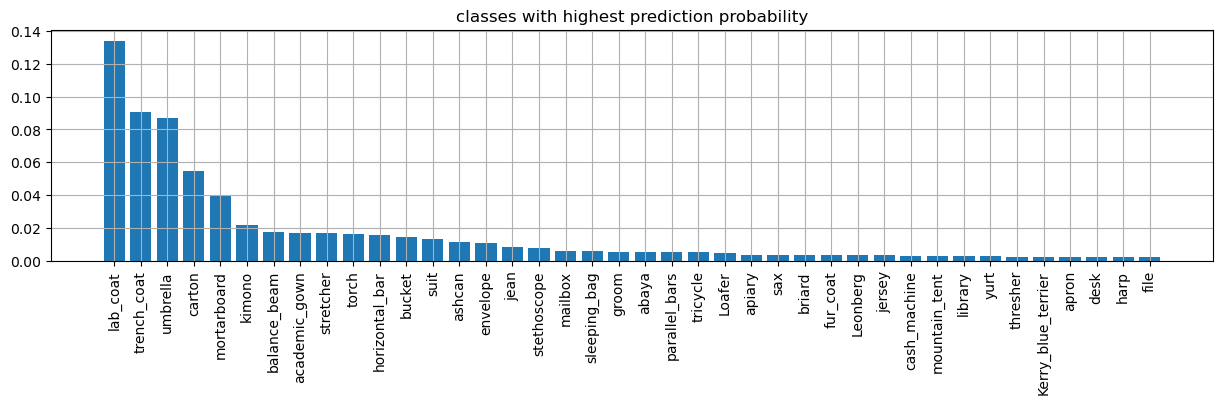

In [42]:
plt.figure(figsize=(15,3))
n = 40
plt.bar(range(n), k[:n].preds.values)
plt.xticks(range(n), k[:n].label.values, rotation="vertical");
plt.title("classes with highest prediction probability")
plt.grid();

observe how we decode prediction classes. We would nee to **align** them with our detectiond dataset.

In [43]:
print ('Predicted:')
k = inception_v3.decode_predictions(pred, top=10)[0]
for i in k:
    print("%10s %20s %.6f"%i)

Predicted:
 n03630383             lab_coat 0.134186
 n04479046          trench_coat 0.090892
 n04507155             umbrella 0.087079
 n02971356               carton 0.054701
 n03787032          mortarboard 0.039948
 n03617480               kimono 0.021387
 n02777292         balance_beam 0.017429
 n02669723        academic_gown 0.016952
 n04336792            stretcher 0.016528
 n04456115                torch 0.016192


## Clasificación de parches, con el modelo ResNet publicado en [TensorFlow Hub](https://www.tensorflow.org/hub)

In [44]:
import tensorflow_hub as hub
import tensorflow as tf

In [45]:
# Load ImageNet labels
classnames = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt', names=["label"])

# Check if model `m` is not already defined
if not 'm' in locals():
    # Load the TensorFlow Hub KerasLayer
    hub_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4")
    
    # Wrap the TensorFlow Hub KerasLayer within a Lambda layer
    wrapped_layer = tf.keras.layers.Lambda(hub_layer)
    
    # Create a Sequential model
    m = tf.keras.Sequential([
        wrapped_layer
    ])
    
    # Build the model with input shape
    m.build([None, 299, 299, 3])


In [46]:
classnames = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt', names=["label"])
if not 'm' in locals():
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4")
    ])
    m.build([None, 299, 299, 3])  

In [47]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 1001)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
preds = m(rimg.reshape(-1,*rimg.shape).astype(np.float32)).numpy()[0]
preds = np.exp(preds)/np.sum(np.exp(preds))
np.sum(preds)

1.0

In [49]:
names = classnames.copy()
names["preds"] = preds
names = names.sort_values(by="preds", ascending=False)
names.head()

label     preds
880     umbrella  0.581176
479       carton  0.035877
870  trench coat  0.031472
835         suit  0.010810
631       Loafer  0.005403

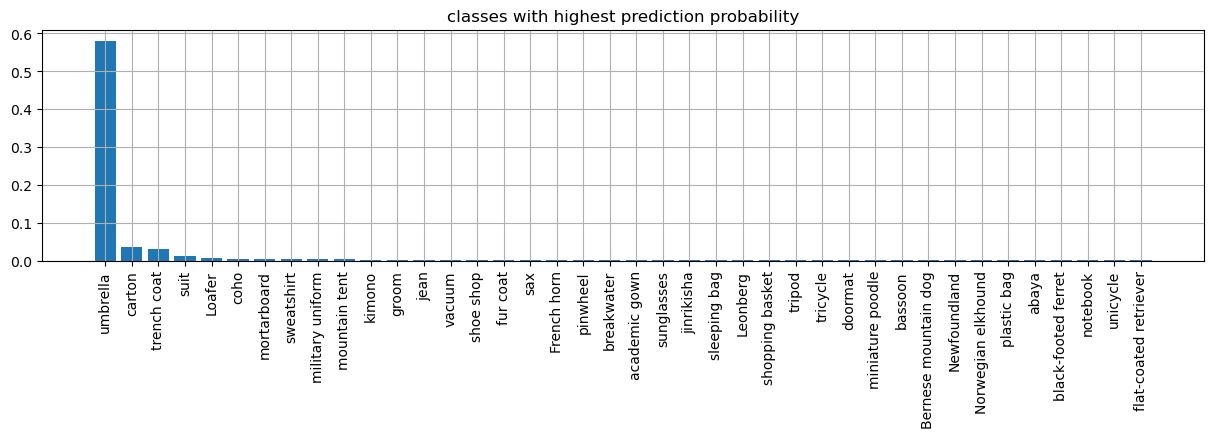

In [50]:
plt.figure(figsize=(15,3))
n = 40
plt.bar(range(n), names[:n].preds.values)
plt.xticks(range(n), names[:n].label.values, rotation="vertical");
plt.title("classes with highest prediction probability")
plt.grid();

## Detectores de una etapa

Este blog: [Explicación de la teoría de YOLO v3](https://medium.com/analytics-vidhya/yolo-v3-theory-explained-33100f6d193) contiene una explicación detallada sobre cómo YOLOv3 construye una predicción para las detecciones.

### Priorización de la región

Un conjunto de formas de cuadros representativos de lo que aparece en el conjunto de datos de entrenamiento. Normalmente se obtienen con KMeans, hay que decidir cuántos. Por ejemplo

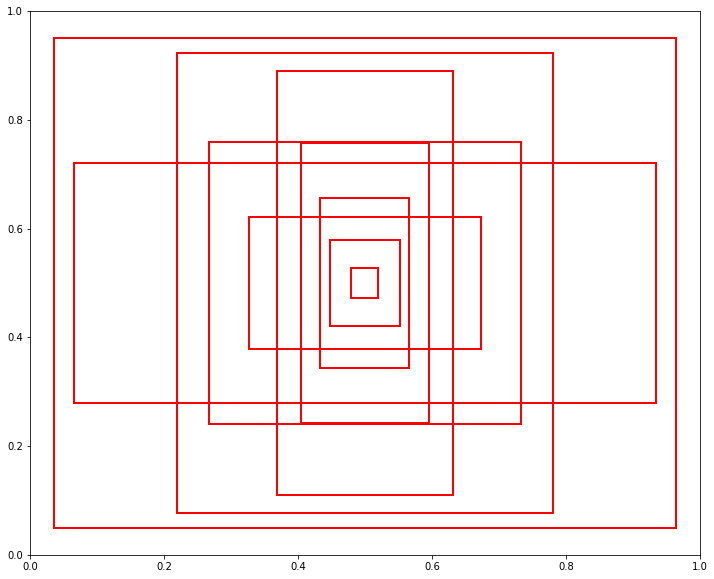

In [51]:
Image("local/imgs/anchor_boxes.png", width=300)

**Imagen de partición fija**

- cada celda de imagen de tamaño fijo es responsable de predecir los objetos cuyo centro se encuentra dentro de esa celda.
- por ejemplo, el punto rojo de abajo señala el centro del árbol y, por tanto, la celda responsable de su predicción.

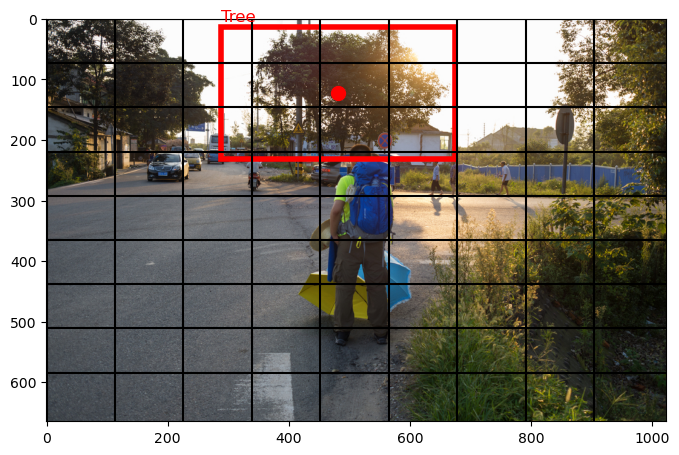

In [52]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.imshow(img)
n = 9
for i in range(n):
    plt.axvline(img.shape[1]//n*i, color="black")
    plt.axhline(img.shape[0]//n*i, color="black")
    
k = boxes.iloc[0]
label = c.loc[k.LabelName].values[0]
ax.add_patch(Rectangle((k.XMin*w,k.YMin*h),(k.XMax-k.XMin)*w,(k.YMax-k.YMin)*h, 
                       linewidth=4,edgecolor='r',facecolor='none'))
plt.text(k.XMin*w, k.YMin*h-10, label, fontsize=12, color="red")
plt.scatter(k.XMin*w+(k.XMax-k.XMin)*w*.5,k.YMin*h+(k.YMax-k.YMin)*h*.5, color="red", s=100)

### **Predicciones**

para **cada celda** y **cada cuadro de anclaje** el modelo hará una predicción que contendrá:

- $t_x$, $t_y$: el desplazamiento del centro del objeto hasta la esquina superior izquierda de la celda.
- $t_w$: $t_y$: los anchos del cuadro delimitador del objeto en relación con el tamaño del cuadro de anclaje.
- $t_0$: un indicador de la probabilidad de que el centro de un objeto esté presente en esa celda: $Pr(object)*IOU(b, object)=\sigma(t_0)$
- $\mathbf{p}_c$: un vector de probabilidades de clase

observa eso:

- $p_w$, $p_h$ son las dimensiones de la caja de anclaje.
- La función sigmoidea $sigma$ se utiliza para limitar las coordenadas de desplazamiento.
- la función exponencial $e$ se utiliza para limitar tamaños $>0$ y proporcionar gradientes más grandes cuando
- Estamos interesados en **ambas** la probabilidad **y** el pagaré del cuadro delimitador.

Por lo tanto, para cada celda y cuadro de anclaje tenemos predicciones de $5+C$, siendo $C$ el número de clases en nuestro conjunto de datos.

Imagen tomada de [YOLO9000: Mejor, más rápido, más fuerte](https://arxiv.org/pdf/1612.08242.pdf)

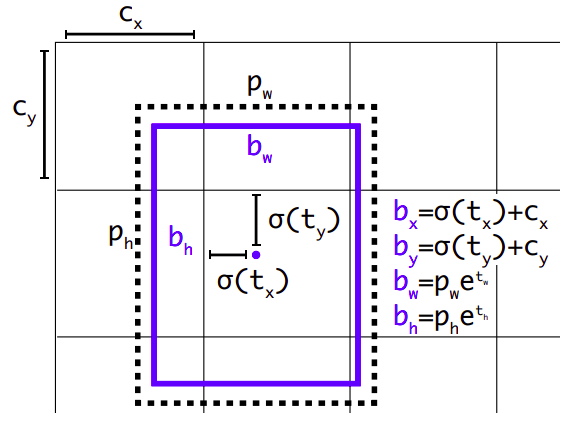

In [53]:
Image("local/imgs/yolo_predictions.png")

Normalmente, las CNN

- reduce las dimensiones de la imagen a $13x13$, o el número de celdas definidas, y hará una convolución $(1,1)$ en 2D con canales $n_a(5+C)$, siendo $n_a$ el número de cuadros de anclaje .

- realice el mismo proceso en capas CNN anteriores (por ejemplo, cuando el mapa de activación es $52\times 52$) o más grande. Entonces hay un conjunto de cuadros de predicción.

Esto estará bien para predecir objetos grandes, pero los pequeños se pierden en la reducción de resolución de CNN. Para superar esto, diferentes arquitecturas utilizan diferentes técnicas:

- YOLO3 realiza predicciones en capas CNN anteriores además de la última.
- RetinaNet reduce la muestra de la imagen y luego desamuestra los mapas de cativación, para integrar (una especie de conexiones omitidas) información semántica de alto nivel de las últimas capas con información espacial de las capas anteriores.

Consulte [este blog] (https://medium.com/@jonathan_hui/what-do-we-learn-from-single-shot-object-detectors-ssd-yolo-fpn-focal-loss-3888677c5f4d) para obtener más intuiciones en este

### Función de pérdida

Observe que estamos haciendo **AMBAS** regresión (para cuadros) **Y** clasificación (para clases de objetos). Luego se debe diseñar una función de pérdida específica para tener esto en cuenta.

Consulte [esta publicación de blog](https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation) y [esta publicación de blog](https://stats.stackexchange.com/questions/373266/ yolo-v3-loss-function) para obtener explicaciones detalladas.

### Supresión no máxima

Finalmente, como puede haber muchas predicciones de cuadros en diferentes celdas y resoluciones, se debe tomar una decisión sobre predicciones superpuestas. Esto es **Supresión no máxima** y puede consultar [este blog](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) para obtener una explicación detallada.